In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from dataset import TextDataset, create_dataloader
from datasets import load_dataset
from perplexity import calc_perplexity
from tokenizer import ByteLevelBPETokenizer, bytes_to_unicode, train_tokenizer
from trainer import Trainer

from transformer import TransformerForCausalLM, model_configs

SEED = 0xC0FFEE

In [3]:
dataset = load_dataset(
    "roneneldan/TinyStories",
    keep_in_memory=True,
    split="train[:10%]",
    trust_remote_code=True,
)
print("\n===\n".join(dataset["text"][:3]))
dataset = dataset.train_test_split(test_size=0.1, seed=SEED)

One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.

Lily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."

Together, they shared the needle and sewed the button on Lily's shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.
===
Once upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun. Beep was a healthy car because he always had good fuel. Good fuel made Beep happy and strong.

One day, Beep was driving in the park when he saw a big tree. The tree had many leaves that were fallin

In [4]:
vocab, merges = train_tokenizer(
    dataset["train"]["text"], vocab_size=1024, special_tokens=["[EOS]"]
)

Loading data:   0%|          | 0/190774 [00:00<?, ?it/s]

Building vocabulary:  25%|##5       | 257/1024 [00:00<?, ?it/s]

In [5]:
random_tokens = [512, 614, 768, 888, 1022]
unicode_to_bytes = {v: k for k, v in bytes_to_unicode().items()}
for token_id in random_tokens:
    token = [k for k, v in vocab.items() if v == token_id][0]
    raw_bytes = bytes([unicode_to_bytes[it] for it in token])
    print(f"Token #{token_id}: '{raw_bytes.decode('utf-8', errors='replace')}'")

Token #512: ' wan'
Token #614: ' wer'
Token #768: 'Yo'
Token #888: ',"'
Token #1022: 'So'


In [6]:
MAX_SEQ_LEN = 128
BATCH_SIZE = 4

tokenizer = ByteLevelBPETokenizer(vocab, merges)

train_dataset = TextDataset(dataset["train"]["text"], tokenizer)
train_dataloader = create_dataloader(
    train_dataset,
    tokenizer.eos_token_id,
    max_seq_len=MAX_SEQ_LEN,
    batch_size=BATCH_SIZE,
    is_train=True,
)

test_dataset = TextDataset(dataset["test"]["text"], tokenizer)
test_dataloader = create_dataloader(
    test_dataset,
    tokenizer.eos_token_id,
    max_seq_len=MAX_SEQ_LEN,
    batch_size=BATCH_SIZE,
    is_train=False,
)

In [7]:
config = model_configs["small"]
model = TransformerForCausalLM(config)
trainer = Trainer(tokenizer, learning_rate=5e-5, n_steps=10_000)

Number of parameters: 79.51M
running on device cuda


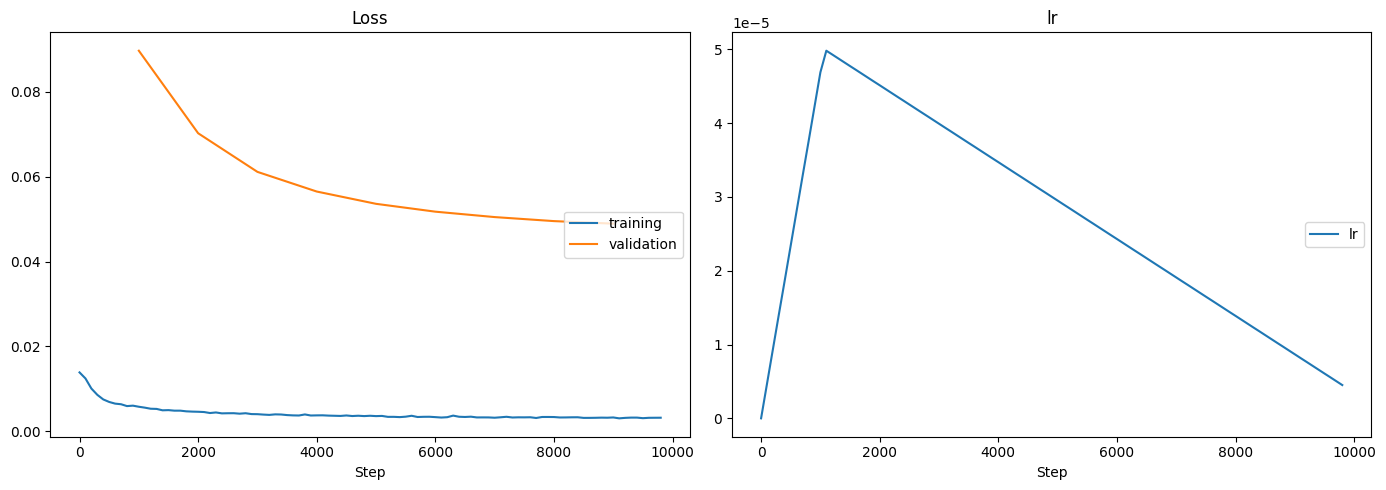

Loss
	training         	 (min:    0.003, max:    0.014, cur:    0.003)
	validation       	 (min:    0.049, max:    0.090, cur:    0.049)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)


KeyboardInterrupt: 

In [ ]:
trainer.run(model, train_dataloader, test_dataloader)

In [8]:
model.load_state_dict(torch.load('/home/ntyazh/study/4_course/NLP/transformer/final.pth'))
model = model.to(trainer.device)

In [33]:
text = "One day, a little girl named Lily found a needle in her room."
input_ids = torch.tensor(tokenizer.encode(text)[:-1], device=trainer.device)[None, :]
model_output = model.generate(
    input_ids, max_new_tokens=200, eos_token_id=tokenizer.eos_token_id, do_sample=True
)
tokenizer.decode(model_output[0].tolist())

'One day, a little girll named Lily found a needle in her room. Lily in her roll in her room. Lily found. Lily pi� in her rollll in her roll in her roll wentt in. Lily wentt in her roll in her rodd in her in her room for her roll in her ropped her roll in in her row her roll in her roll in her should Iht in her roll in her room. Lily from her roll in her row in her nobove in her roll in her room. Lily found her room in her roll in in her helped in her ro in her rother in her room in her ro in her roll found her in her roll in, in her in her roll in her in in her room her room and in her in her in her ro in in and in her in her in her in her in in her in her in in her in in in in and in in in'

In [ ]:
print("Perplexity for train set:", calc_perplexity(model, train_dataloader, tokenizer.eos_token_id))

Computing ppl: 100%|██████████| 47693/47693 [1:42:48<00:00,  7.73it/s]

Perplexity for train set: 7.085231323682254


In [ ]:
print("Perplexity for validation set:", calc_perplexity(model, test_dataloader, tokenizer.eos_token_id))

Computing ppl: 100%|██████████| 5300/5300 [11:25<00:00,  7.73it/s]


Perplexity for validation set: 7.223383661738697
